In [1]:
!pip install google-generativeai
!pip install spacy

In [2]:
import re

def clean_text(text):
    """
    Очищает текст от мусора:
    - Приводит к нижнему регистру.
    - Удаляет цифры.
    - Удаляет знаки препинания и специальные символы.
    - Заменяет множественные пробелы на одиночные.
    """
    text = text.lower() # Приводим к нижнему регистру
    text = re.sub(r'\d+', '', text) # Удаляем цифры
    text = re.sub(r'[^\w\s]', '', text) # Удаляем все, кроме букв и пробелов
    text = re.sub(r'\s+', ' ', text).strip() # Заменяем множественные пробелы на один и удаляем пробелы по краям
    return text

# Интеграция в load_texts_from_directory:
# Найдите вашу функцию load_texts_from_directory в вашем research_draft.py
# и добавьте вызов clean_text внутри цикла, вот так:

def load_texts_from_directory(base_dir="corpus"):
    all_texts = []
    for category_dir in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category_dir)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(".txt"):
                    filepath = os.path.join(category_path, filename)
                    lines_read = []
                    line_count = 0
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            for line in f:
                                if line_count < 3000: # Take only the first 300 lines
                                    lines_read.append(line)
                                    line_count += 1
                                else:
                                    break 
                        raw_content = "".join(lines_read)
                        content = clean_text(raw_content) 
                        
                        all_texts.append({
                            "Text Category": category_dir,
                            "Filename": filename,
                            "Content": content
                        })
                    except Exception as e:
                        print(f"Error reading file {filepath}: {e}")
    return all_texts

In [3]:
import google.generativeai as genai
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import re
from collections import Counter

# --- 1. Настройка Gemini API ---
API_KEY = "GOOGLE_API_KEY" 

if API_KEY is None:
    print("Error: GOOGLE_API_KEY environment variable is not set.")
    print("Please set it or insert your key directly into the code (not recommended for production).")

genai.configure(api_key=API_KEY)
model = genai.GenerativeModel('gemini-pro')

def generate_text_with_gemini(prompt, temperature=0.7):
    try:
        response = model.generate_content(prompt, generation_config={'temperature': temperature})
        return response.text
    except Exception as e:
        return f"Failed to generate text: {e}"


/home/chulpan/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:

# --- 2. Загрузка spaCy модели для NLP ---
try:
    nlp = spacy.load("en_core_web_md")
except OSError:
    print("Downloading spaCy model 'en_core_web_md'...")
    os.system("python -m spacy download en_core_web_md")
    nlp = spacy.load("en_core_web_md")

In [5]:
# --- 3. Функции для детектирования маркеров креативности ---

def detect_metaphoricity_improved(text):
    doc = nlp(text)
    incongruity_scores = []
    
    # Минимальный порог сходства для пары, чтобы считаться потенциальной метафорой.
    # Если сходство ниже этого, слова слишком далеки, чтобы быть связанной метафорой.
    # Это эвристическое значение, которое можно настроить.
    MIN_SIMILARITY_THRESHOLD = 0.2 

    for token in doc:
        if not token.has_vector or token.vector_norm == 0:
            continue

        # Check for ADJ modifying NOUN
        if token.pos_ == "ADJ" and token.dep_ == "amod" and token.head.pos_ == "NOUN":
            if token.head.has_vector and token.head.vector_norm:
                similarity = token.similarity(token.head)
                if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                    incongruity_scores.append(1 - similarity)
        
        # Check for VERB with NOUN as subject or object
        if token.pos_ == "VERB":
            # Check for nominal subject (nsubj)
            for child in token.children:
                if child.dep_ == "nsubj" and child.pos_ == "NOUN":
                    if child.has_vector and child.vector_norm:
                        similarity = token.similarity(child)
                        if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                            incongruity_scores.append(1 - similarity)
            # Check for direct object (dobj)
            for child in token.children:
                if child.dep_ == "dobj" and child.pos_ == "NOUN":
                    if child.has_vector and child.vector_norm:
                        similarity = token.similarity(child)
                        if similarity > MIN_SIMILARITY_THRESHOLD: # Только если слова достаточно связаны
                            incongruity_scores.append(1 - similarity)

    if not incongruity_scores:
        return 0.0
    
    return np.mean(incongruity_scores)


def detect_synesthesia_improved(text):
    """
    Определяет синестезию, ища грамматически связанные слова (ADJ-NOUN, VERB-NOUN),
    чьи доминирующие сенсорные модальности различаются.
    Использует усредненные векторы "сенсорных семян".
    Более высокий балл указывает на большую вероятность синестезии.
    """
    doc = nlp(text)
    synesthesia_count = 0
    total_checked_pairs = 0

    sense_seeds = {
        "visual": ["see", "light", "color", "bright", "dark", "view", "vision", "gaze", "vibrant"],
        "auditory": ["hear", "sound", "noise", "loud", "quiet", "listen", "melody", "whisper", "scream"],
        "olfactory": ["smell", "scent", "fragrant", "odor", "perfume", "pungent", "aroma"],
        "gustatory": ["taste", "flavor", "sweet", "sour", "bitter", "spicy", "delicious"],
        "tactile": ["touch", "feel", "soft", "hard", "cold", "warm", "smooth", "rough", "texture"]
    }

    sense_vectors = {}
    for sense, words in sense_seeds.items():
        vectors = [nlp.vocab[word].vector for word in words if nlp.vocab[word].has_vector and nlp.vocab[word].vector_norm > 0]
        if vectors:
            sense_vectors[sense] = np.mean(vectors, axis=0)
            
            sense_vectors[sense] = sense_vectors[sense] / np.linalg.norm(sense_vectors[sense])
        else:
            sense_vectors[sense] = None 

    if not sense_vectors:
        return 0.0

    for token in doc:
        if not token.has_vector or token.vector_norm == 0:
            continue

        if token.pos_ == "ADJ" and token.dep_ == "amod" and token.head.pos_ == "NOUN":
            if token.head.has_vector and token.head.vector_norm > 0:
                total_checked_pairs += 1
                adj_vec = token.vector
                noun_vec = token.head.vector

                adj_dominant_sense = None
                adj_max_similarity = -1
                for sense, s_vec in sense_vectors.items():
                    if s_vec is not None:
                        sim = np.dot(adj_vec, s_vec) 
                        if sim > adj_max_similarity:
                            adj_max_similarity = sim
                            adj_dominant_sense = sense

                noun_dominant_sense = None
                noun_max_similarity = -1
                for sense, s_vec in sense_vectors.items():
                    if s_vec is not None:
                        sim = np.dot(noun_vec, s_vec)
                        if sim > noun_max_similarity:
                            noun_max_similarity = sim
                            noun_dominant_sense = sense
                
                if adj_dominant_sense and noun_dominant_sense and adj_dominant_sense != noun_dominant_sense:
                    synesthesia_count += 1
        
    if total_checked_pairs == 0:
        return 0.0
    
    return (synesthesia_count / total_checked_pairs)


def calculate_associative_distance_simple(text):
    doc = nlp(text.lower())
    words_with_vectors = [token.vector for token in doc if token.has_vector and token.is_alpha and not token.is_stop]
    
    if len(words_with_vectors) < 2:
        return 0.0

    distances = []
    # Calculate average cosine distance between all pairs of words
    # This is a proxy for "associative distance" - higher distance = more novel/less predictable associations
    for i in range(len(words_with_vectors)):
        for j in range(i + 1, len(words_with_vectors)):
            vec1 = words_with_vectors[i]
            vec2 = words_with_vectors[j]
            # Calculate cosine similarity (dot product of normalized vectors)
            similarity = np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2) + 1e-8)
            # Distance is 1 - similarity (so higher distance for lower similarity)
            distances.append(1 - similarity)
    
    return np.mean(distances) if distances else 0.0

In [6]:
# --- 4. Загрузка и анализ текстов из папок ---

def load_texts_from_directory(base_dir="corpus"):
    all_texts = []
    for category_dir in os.listdir(base_dir):
        category_path = os.path.join(base_dir, category_dir)
        if os.path.isdir(category_path):
            for filename in os.listdir(category_path):
                if filename.endswith(".txt"):
                    filepath = os.path.join(category_path, filename)
                    lines_read = []
                    line_count = 0
                    try:
                        with open(filepath, 'r', encoding='utf-8') as f:
                            for line in f:
                                if line_count < 300: # Take only the first 300 lines
                                    lines_read.append(line)
                                    line_count += 1
                                else:
                                    break # Stop reading after 300 lines
                        content = "".join(lines_read)
                        all_texts.append({
                            "Text Category": category_dir,
                            "Filename": filename,
                            "Content": content
                        })
                    except Exception as e:
                        print(f"Error reading file {filepath}: {e}")
    return all_texts

# Создаем папку 'corpus' и подпапки, если их нет
# if not os.path.exists("corpus/poem"): os.makedirs("corpus/poem")
# if not os.path.exists("corpus/prose"): os.makedirs("corpus/prose")
# if not os.path.exists("corpus/song"): os.makedirs("corpus/song")
# if not os.path.exists("corpus/llm"): os.makedirs("corpus/llm")


# print("Generating LLM text (this might take a few seconds)...")
# llm_prompt = "Write a short, highly metaphorical and slightly surrealist poem about urban decay and rebirth, including elements of synesthesia."
# generated_llm_text = generate_text_with_gemini(llm_prompt, temperature=0.9)
# with open("corpus/llm/llm_creative_text.txt", "w", encoding="utf-8") as f:
#     f.write(generated_llm_text)

In [7]:


print("\n--- Analyzing text samples ---")

text_data = load_texts_from_directory()
results = []

for item in text_data:
    category = item["Text Category"]
    filename = item["Filename"]
    content = item["Content"] 

    print(f"\nAnalyzing: {category}/{filename}")
    
    metaphoricity = detect_metaphoricity_improved(content) 
    
    synesthesia = detect_synesthesia_improved(content)
    associativity = calculate_associative_distance_simple(content) 
    
    print(f"  Metaphoricity: {metaphoricity:.2f}")
    print(f"  Synesthesia: {synesthesia:.2f}")
    print(f"  Associativity: {associativity:.2f}")
    
    results.append({
        "Text Category": category,
        "Filename": filename,
        "Metaphoricity Score": metaphoricity,
        "Synesthesia Score": synesthesia,
        "Associativity Score": associativity,
        "Text Content": content
    })

df_results = pd.DataFrame(results)

df_category_avg = df_results.groupby('Text Category').mean(numeric_only=True).reset_index()

print("\n--- Summary of results by category (average scores) ---")
print(df_category_avg[['Text Category', 'Metaphoricity Score', 'Synesthesia Score', 'Associativity Score']].round(2))


--- Analyzing text samples ---

Analyzing: science/text1.txt
  Metaphoricity: 0.63
  Synesthesia: 0.31
  Associativity: 0.79

Analyzing: llm/text1.txt
  Metaphoricity: 0.64
  Synesthesia: 0.63
  Associativity: 0.82

Analyzing: prose/prose2.txt
  Metaphoricity: 0.65
  Synesthesia: 0.53
  Associativity: 0.81

Analyzing: prose/prose1.txt
  Metaphoricity: 0.66
  Synesthesia: 0.38
  Associativity: 0.78

Analyzing: poem/poem1.txt
  Metaphoricity: 0.65
  Synesthesia: 0.62
  Associativity: 0.81

Analyzing: poem/poem2.txt
  Metaphoricity: 0.68
  Synesthesia: 0.82
  Associativity: 0.83

Analyzing: song/song2.txt
  Metaphoricity: 0.56
  Synesthesia: 0.27
  Associativity: 0.67

Analyzing: song/song1.txt
  Metaphoricity: 0.64
  Synesthesia: 1.00
  Associativity: 0.74

--- Summary of results by category (average scores) ---
  Text Category  Metaphoricity Score  Synesthesia Score  Associativity Score
0           llm                 0.64               0.63                 0.82
1          poem        


--- Creating plots ---


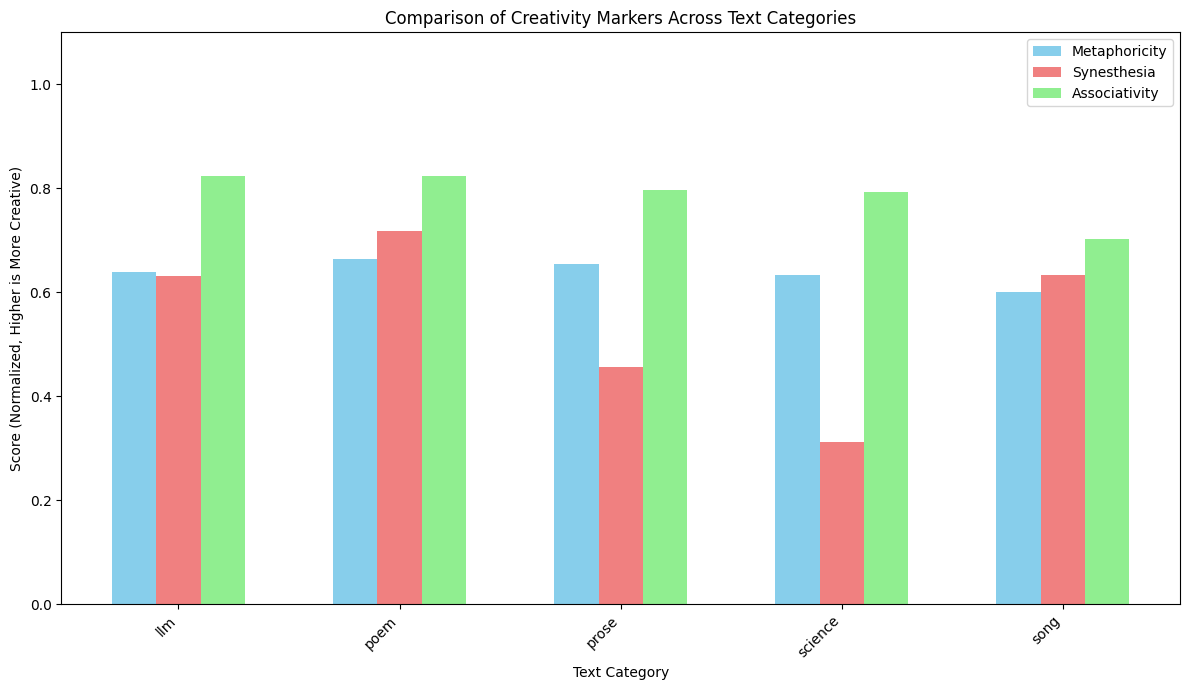


Plot saved as creativity_markers_comparison.png


In [9]:
# --- 5. Визуализация результатов ---

print("\n--- Creating plots ---")

plt.figure(figsize=(12, 7))
bar_width = 0.2
index = np.arange(len(df_category_avg['Text Category']))

plt.bar(index - bar_width, df_category_avg['Metaphoricity Score'], bar_width, label='Metaphoricity', color='skyblue')
plt.bar(index, df_category_avg['Synesthesia Score'], bar_width, label='Synesthesia', color='lightcoral')
plt.bar(index + bar_width, df_category_avg['Associativity Score'], bar_width, label='Associativity', color='lightgreen')

plt.xlabel('Text Category')
plt.ylabel('Score (Normalized, Higher is More Creative)')
plt.title('Comparison of Creativity Markers Across Text Categories')
plt.xticks(index, df_category_avg['Text Category'], rotation=45, ha='right')
plt.ylim(0, max(df_category_avg[['Metaphoricity Score', 'Synesthesia Score', 'Associativity Score']].values.max(), 1.0) * 1.1)
plt.legend()
plt.tight_layout()
plt.savefig('creativity_markers_comparison.png')
plt.show()

print("\nPlot saved as creativity_markers_comparison.png")